In [1]:
%matplotlib inline
import random
import time
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow.compat.v1 as tf
from pylab import rcParams
import os
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MODEL_PATH = '../data/model_artif/'
#MODEL_PATH = ['/content/drive/MyDrive']
SAMPLES_PATHS = ['/content/drive/MyDrive/artificial_samples/artificial']

In [4]:
EPOCH = 100

In [5]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Import data

In [6]:
def LoadImage(fname):
    return io.imread(fname)[:,:] / 255.

In [7]:
def LoadAnnotation(fname):
    with open(fname) as data_file:    
        data = json.load(data_file)

    left = data["objects"][0]["points"]["exterior"][0][0]
    top = data["objects"][0]["points"]["exterior"][0][1]
    right = data["objects"][0]["points"]["exterior"][1][0]
    bottom = data["objects"][0]["points"]["exterior"][1][1]
    
    return [left, top, right, bottom]

In [8]:
def ReadDirFiles(dname):
    paths = []
    for file in os.listdir(os.path.join(dname, "img")):
        bname = os.path.basename(file).split(".")[0]
        
        img_name = os.path.join(dname, "img", file)
        ann_name = os.path.join(dname, "ann", bname + ".json")
        paths.append((img_name, ann_name))
    return paths

In [9]:
def ReadPaths(paths):
    all_paths = []
    for path in paths:
        temp_paths = ReadDirFiles(path)
        all_paths.extend(temp_paths)
    return all_paths

In [10]:
def get_tags(fname):
    with open(fname) as data_file:
        data = json.load(data_file)  
    tags = data["tags"]
    return tags

In [11]:
def train_test_split(paths, train_tag="train", test_tag="test"):
    train_paths = []
    test_paths = []
    for path in paths:
        img_path, ann_path = path
        tags = get_tags(ann_path)
        if train_tag in tags:
            train_paths.append(path)
        if test_tag in tags:
            test_paths.append(path)
    return train_paths, test_paths

In [12]:
all_paths = ReadPaths(SAMPLES_PATHS)
tr_paths, te_paths = train_test_split(all_paths)

print(len(tr_paths))
print(len(te_paths))

44
6


In [13]:
def LoadData(paths):
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(LoadImage(img_path))
        ys.append(LoadAnnotation(ann_path))
    
    return np.array(xs), np.array(ys)

In [14]:
X_train, Y_train = LoadData(tr_paths)
X_test, Y_test = LoadData(te_paths)

print("check shapes:")
print("X_train - ", X_train.shape)
print("Y_train - ", Y_train.shape)
print("X_test - ", X_test.shape)
print("Y_test - ", Y_test.shape)

check shapes:
('X_train - ', (44, 64, 128))
('Y_train - ', (44, 4))
('X_test - ', (6, 64, 128))
('Y_test - ', (6, 4))


### Show sample images

<Figure size 1008x576 with 0 Axes>

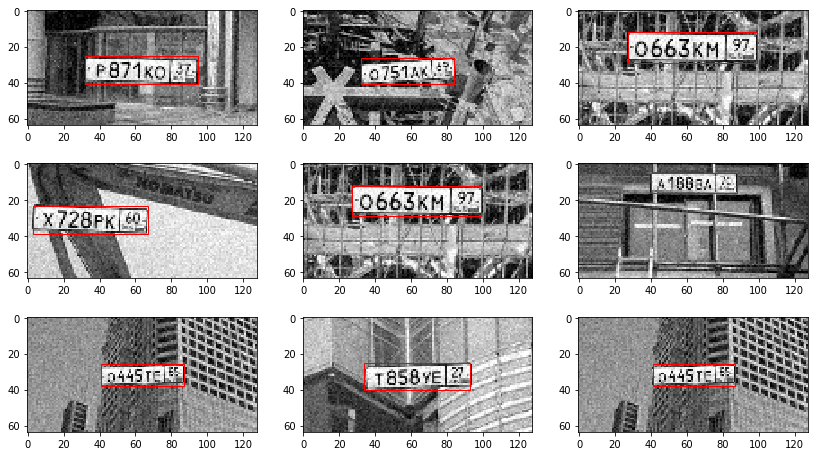

In [15]:
def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_images(images, labels):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(9, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()    
    
xs = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]                   
plot_images(X_train[xs], Y_train[xs])  

## Batch iterator

In [16]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

## Build Tensorflow neural net

In [17]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

In [18]:
def weight_variable(name, shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable(name, initializer=initial)

def bias_variable(name, shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    

In [19]:
PIXEL_COUNT = X_train.shape[1] * X_train.shape[2]
LABEL_COUNT = Y_train.shape[1]
# Create placeholders for image data and expected point positions

class Model(object):
    xxx = 0
    
# Build neural network
def build_model():
    x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
    y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

    x_image = tf.reshape(x_placeholder, [-1, 64, 128, 1])
    # Convolution Layer 1
    W_conv1 = weight_variable("w1", [3, 3, 1, 32])
    b_conv1 = bias_variable("b1", [32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    # Convolution Layer 2
    W_conv2 = weight_variable("w2", [2, 2, 32, 64])
    b_conv2 = bias_variable("b2", [64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable("w3", [2, 2, 64, 128])
    b_conv3 = bias_variable("b3", [128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 8*16*128])
    W_fc1 = weight_variable("w4", [8*16*128, 500])
    b_fc1 = bias_variable("b4", [500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)   
    # Dense layer 2
    W_fc2 = weight_variable("w5", [500, 500])
    b_fc2 = bias_variable("b5", [500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)  
    # Output layer
    W_out = weight_variable("w6", [500, LABEL_COUNT])
    b_out = bias_variable("b6", [LABEL_COUNT])
    
    output = tf.matmul(h_fc2, W_out) + b_out
    
    model = Model()
    model.x_placeholder = x_placeholder
    model.y_placeholder = y_placeholder
    model.output = output
    
    return model

### Train

In [20]:
X2_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
Y2_train = Y_train / (64.0, 32.0, 64.0, 32.0) - 1.0

X2_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
Y2_test = Y_test / (64.0, 32.0, 64.0, 32.0) - 1

dataset = Dataset(X2_train, Y2_train)

In [21]:
g = tf.Graph()
with g.as_default():
    session = tf.Session()
    
    model = build_model()
    loss = mse(model.y_placeholder, model.output)
    
    saver = tf.train.Saver()
    start_time = time.time()
    best_score = 1

    train_step = tf.train.AdamOptimizer().minimize(loss)

    session = tf.InteractiveSession()
    session.run(tf.global_variables_initializer())
    #saver.restore(session, os.path.join(MODEL_PATH, "model"))

    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={model.x_placeholder: batch_x, model.y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch:
            last_epoch = dataset.epoch_completed()
            score_test = loss.eval(feed_dict={model.x_placeholder: X2_test, model.y_placeholder: Y2_test})
            if score_test < best_score:
                best_score = score_test
                saver.save(session, os.path.join(MODEL_PATH, "model"))
            if dataset.epoch_completed() % 1 == 0:
                epm = 60 * dataset.epoch_completed() / (time.time()-start_time)
                print('Epoch: %d, Score: %f, Epoch per minute: %f' % (dataset.epoch_completed(), score_test, epm))
    print('Finished in %f seconds.' % (time.time()-start_time)) 
    
    session.close()

W1118 07:56:13.818731 140326746605440 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1635: calling __init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch: 0, Score: 733.786926, Epoch per minute: 0.000000
Epoch: 1, Score: 30.412634, Epoch per minute: 33.515920
Epoch: 2, Score: 30.221033, Epoch per minute: 50.404750
Epoch: 3, Score: 0.813312, Epoch per minute: 58.804599
Epoch: 4, Score: 7.442107, Epoch per minute: 65.812675
Epoch: 5, Score: 1.575214, Epoch per minute: 71.032883
Epoch: 6, Score: 1.180681, Epoch per minute: 74.730565
Epoch: 7, Score: 1.798889, Epoch per minute: 77.400409
Epoch: 8, Score: 0.298611, Epoch per minute: 78.894191
Epoch: 9, Score: 0.514482, Epoch per minute: 80.601575
Epoch: 10, Score: 0.646653, Epoch per minute: 82.528064
Epoch: 11, Score: 0.071478, Epoch per minute: 82.658807
Epoch: 12, Score: 0.253592, Epoch per minute: 83.929651
Epoch: 13, Score: 0.226286, Epoch per minute: 84.993206
Epoch: 14, Score: 0.037812, Epoch per minute: 85.279810
Epoch: 15, Score: 0.105683, Epoch per minute: 86.163533
Epoch: 16, Score: 0.057944, Epoch per minute: 87.072105
Epoch: 17, Score: 0.044548, Epoch per minute: 87.933611

### Show test set predictions

<Figure size 1008x576 with 0 Axes>

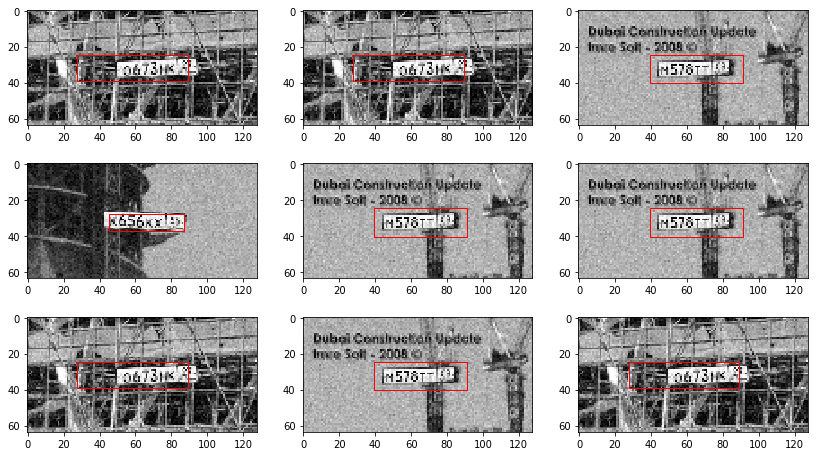

In [22]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    ids = [random.randint(0, X2_test.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_test[ids]})
    plot_images(X_test[ids], (predictions+1) * (64, 32, 64, 32))
    session.close()

### Show train set predictions

<Figure size 1008x576 with 0 Axes>

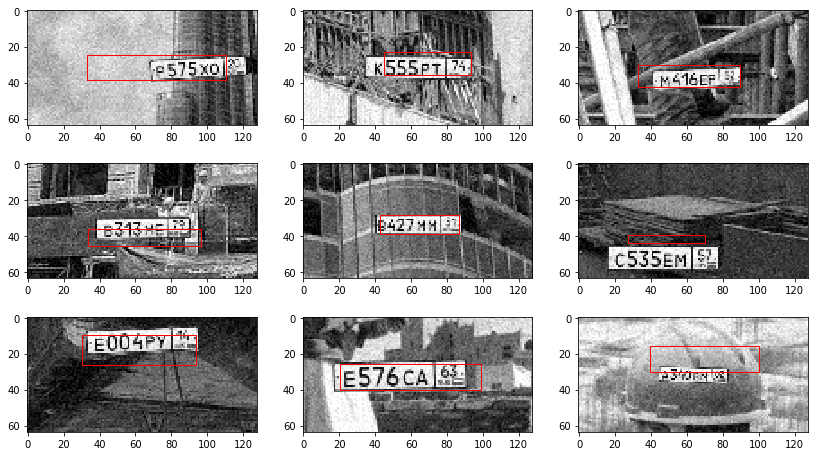

In [23]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    
    ids = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_train[ids]})
    plot_images(X_train[ids], (predictions+1) * (64, 32, 64, 32))

    session.close()